In [1]:
import functools
import jax
import os
import html

from datetime import datetime
from jax import numpy as jp
jax.config.update("jax_debug_nans", False)
jax.config.update("jax_enable_x64", True)
import matplotlib.pyplot as plt

from IPython.display import HTML, clear_output, display

import flax
from brax import envs
from brax.io import model
from brax.io import json
from brax.io import html

import shutil

from src.pods.Pods import train as train_pods
from src.hds.Hds import train as train_hds
from src.env.Pendulum import InvertedPendulum
import pickle




In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
print(jax.devices())

gpu
[cuda(id=0)]


In [3]:
env = InvertedPendulum(target=jp.array([1]))
state = jax.jit(env.reset)(rng=jax.random.PRNGKey(seed=0))

#HTML(html.render(env.sys, [state.pipeline_state]))

In [4]:
ckpt_dir = './tmp/flax_ckpt'

if os.path.exists(ckpt_dir):
    shutil.rmtree(ckpt_dir)  # Remove any existing checkpoints from the last notebook run.

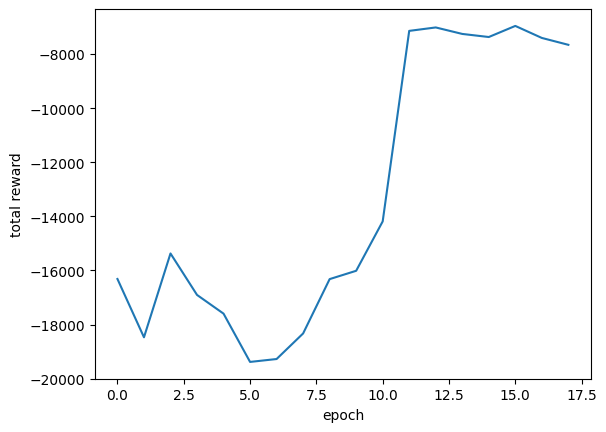

big epoch: 17 small epoch: 0 Loss 1.3300241155466552e-05
big epoch: 17 small epoch: 1 Loss 1.018105682738454e-05
big epoch: 17 small epoch: 2 Loss 9.020846306349397e-06
-7782.321679705521


In [5]:

def progress_f(x_data,y_data,epoch,reward):
    print(reward)
    x_data.append(epoch)
    y_data.append(reward)
    clear_output(wait=True)
    plt.xlabel('epoch')
    plt.ylabel('total reward')
    plt.plot(x_data, y_data)
    plt.show()

#policy = train_hds(env,trajectory_length=100 ,num_samples=50,epochs=4, inner_epochs=20, alpha_a=1e-5, init_learning_rate=1e-3, init_noise=0.1, noise_decay=0.5, progress_fn=progress_f)
policy = train_pods(env,trajectory_length=100 ,num_samples=100,epochs=50, inner_epochs=20, alpha_a=5e-5, init_learning_rate=1e-3, progress_fn=progress_f)

In [ ]:
f = open("reward.txt", "w")
g = open("actions.txt", "w")
inference_fn = policy()
rollout = []
rng = jax.random.PRNGKey(seed=1)
state = env.reset(rng=rng)
reward = []
actions = []
for _ in range(1000):
  rollout.append(state.pipeline_state)
  act_rng, rng = jax.random.split(rng)
  #print(state.obs)
  act = inference_fn(state.obs)
  print(act)
  reward.append(state.reward)
  state = env.step(state, act)
  #print(state.reward)
  actions.append(act)

  
print(reward, file=f)
print(actions, file=g)

[0.64359282]
[0.75642246]
[0.53987732]
[0.04370654]
[-0.45349085]
[-0.40047099]
[-0.15126539]
[0.05201504]
[0.1885987]
[0.2696563]
[0.31690633]
[0.33814999]
[0.32655209]
[0.2742721]
[0.18332979]
[0.08843123]
[0.00342656]
[-0.06186828]
[-0.09827642]
[-0.06099588]
[-0.00886899]
[0.06291079]
[0.16676664]
[0.34782892]
[0.53697976]
[0.65626021]
[0.69937808]
[0.68572678]
[0.64847463]
[0.61199072]
[0.53424392]
[0.41440133]
[0.24710608]
[0.21377707]
[0.15989349]
[0.14531422]
[0.17079008]
[0.21755518]
[0.25339169]
[0.26464478]
[0.27769777]
[0.28623254]
[0.29580829]
[0.29494832]
[0.27177204]
[0.24227659]
[0.22016656]
[0.20208059]
[0.19217201]
[0.18337788]
[0.18273488]
[0.18353136]
[0.18082338]
[0.17771738]
[0.18229758]
[0.19138085]
[0.20026798]
[0.20568841]
[0.20984189]
[0.21382391]
[0.21522768]
[0.2210868]
[0.22649518]
[0.23213358]
[0.23713566]
[0.23882493]
[0.23736904]
[0.23339237]
[0.22816278]
[0.22169598]
[0.21542781]
[0.21026824]
[0.20602726]
[0.2028552]
[0.20155542]
[0.20067152]
[0.2001556

In [ ]:

yes=html.render(env.sys.replace(dt=env.dt), rollout)
with open("data.html", "w") as file:
    file.write(yes)